In [2]:
# Block 1: Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# For ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance



In [3]:
#Load all CSVs into one DataFrame

data_folder = "datasets"

# Just list and sort all files (since they're all CSVs anyway)
csv_files = sorted(os.listdir(data_folder))

dfs = [pd.read_csv(os.path.join(data_folder, file)) for file in csv_files]

# Merge everything
data = pd.concat(dfs, ignore_index=True)

print("Full dataset shape:", data.shape)
print("Columns:", list(data.columns))
print("Class distribution:\n", data["label"].value_counts())


Full dataset shape: (5300000, 40)
Columns: ['url', 'label', 'dots', 'at', 'equals', 'slashes', 'hyphens', 'colons', 'question_marks', 'digits', 'and', 'underscore', 'tilde', 'percent', 'lowercase', 'uppercase', 'upper_to_lower_ratio', 'is_https', 'url_length', 'domain_length', 'path_length', 'path_depth', 'query_length', 'query_count', 'fragment_length', 'se_url', 'se_domain', 'se_path', 'se_query', 'se_fragment', 'cte_domain', 'is_domain_ip', 'tld', 'is_tld_iana_reg', 'is_mtld', 'subdomains', 'special_chars', 'digit_to_length_ratio', 'char_to_length_ratio', 'specialchar_to_length_ratio']
Class distribution:
 label
0    3033558
1    2266442
Name: count, dtype: int64


In [5]:
#Sampling + dropping non-feature columns

# Drop columns we don't use for feature importance
# 'url' is text, 'tld' is categorical (can be used later if encoded)
X = data.drop(columns=["url", "tld", "label"])
y = data["label"]

# Take a 10% sample (adjust frac as needed)
sample_frac = 0.1
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y.loc[X_sample.index]

print("Sampled shape:", X_sample.shape)
print("Target distribution in sample:\n", y_sample.value_counts())


Sampled shape: (530000, 37)
Target distribution in sample:
 label
0    303929
1    226071
Name: count, dtype: int64


                  feature  importance
15               is_https    0.262478
28             cte_domain    0.062468
24              se_domain    0.059358
13              uppercase    0.053668
0                    dots    0.052879
4                 hyphens    0.052421
14   upper_to_lower_ratio    0.046281
23                 se_url    0.043469
17          domain_length    0.040907
32             subdomains    0.039662
25                se_path    0.032083
7                  digits    0.028650
34  digit_to_length_ratio    0.027377
18            path_length    0.026586
16             url_length    0.026450
35   char_to_length_ratio    0.025190
12              lowercase    0.023053
3                 slashes    0.019211
19             path_depth    0.015174
9              underscore    0.009414


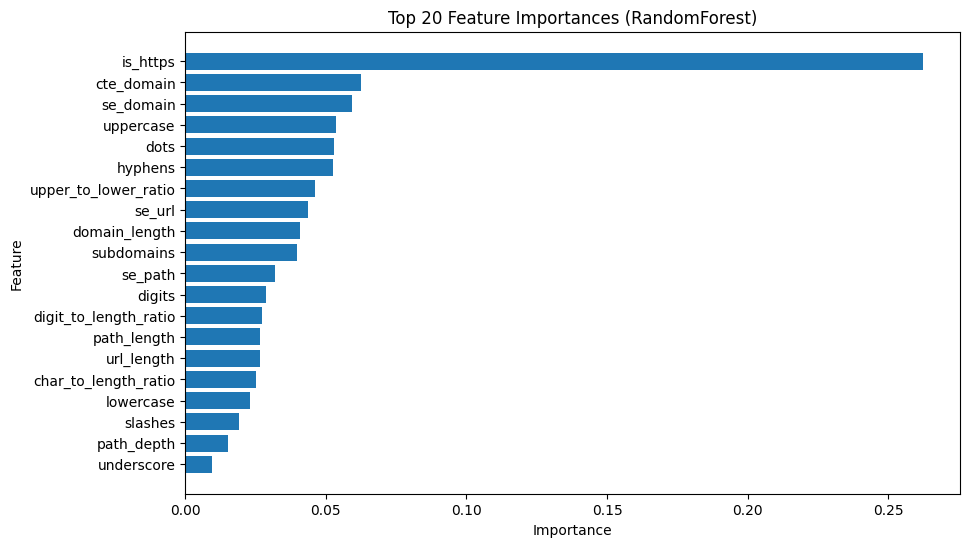

In [6]:
# RandomForest Feature Importance

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a RandomForest (quick and dirty for feature importance)
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1
)
rf.fit(X_sample, y_sample)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_sample.columns
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)

print(feat_imp.head(20))

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"].head(20), feat_imp["importance"].head(20))
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()


C:\Users\Skeletron\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:31:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                  feature  importance
15               is_https    0.717793
13              uppercase    0.050667
30        is_tld_iana_reg    0.020897
4                 hyphens    0.020529
28             cte_domain    0.017407
14   upper_to_lower_ratio    0.013707
0                    dots    0.013497
32             subdomains    0.012166
7                  digits    0.011019
24              se_domain    0.009437
17          domain_length    0.008357
9              underscore    0.006879
10                  tilde    0.006458
11                percent    0.006297
3                 slashes    0.006199
1                      at    0.006186
31                is_mtld    0.005647
29           is_domain_ip    0.004979
34  digit_to_length_ratio    0.004803
2                  equals    0.004723


C:\Users\Skeletron\AppData\Local\Temp\ipykernel_19892\63318676.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


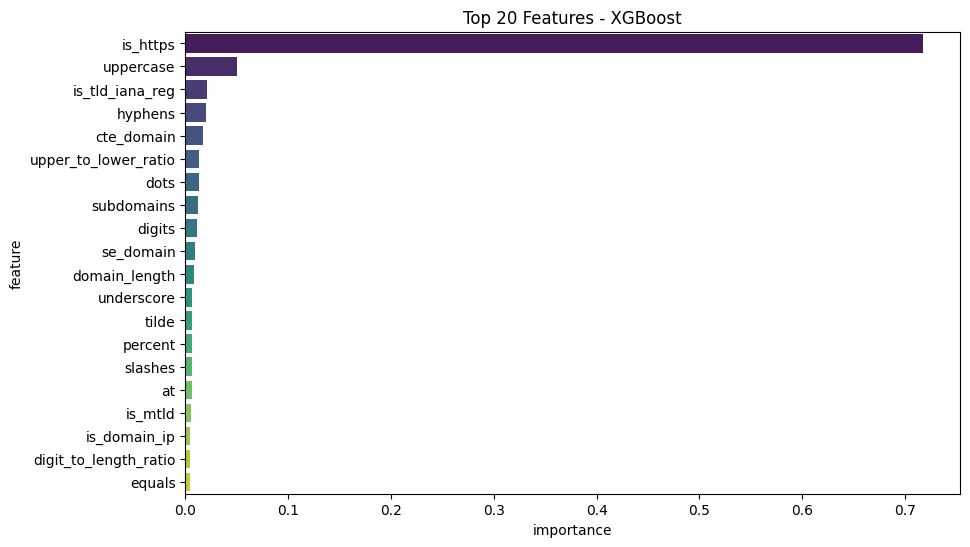

In [7]:
# --- Block: XGBoost Feature Importance ---

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Train a lightweight XGBoost model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_sample, y_sample)

# Get feature importances
xgb_importances = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

print(xgb_importances.head(20))

# Plot (same style as RF)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="importance", y="feature",
    data=xgb_importances.head(20),
    palette="viridis"
)
plt.title("Top 20 Features - XGBoost")
plt.show()


[LightGBM] [Info] Number of positive: 226071, number of negative: 303929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3874
[LightGBM] [Info] Number of data points in the train set: 530000, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.426549 -> initscore=-0.295945
[LightGBM] [Info] Start training from score -0.295945
                  feature  importance_gain
15               is_https     1.343395e+06
28             cte_domain     1.936616e+05
13              uppercase     1.744341e+05
4                 hyphens     1.657886e+05
24              se_domain     1.201698e+05
0                    dots     1.114183e+05
7                  digits     1.113990e+05
32             subdomains     1.009639e+05
14   upper_to_lower_ratio     7.338036e+04
17       

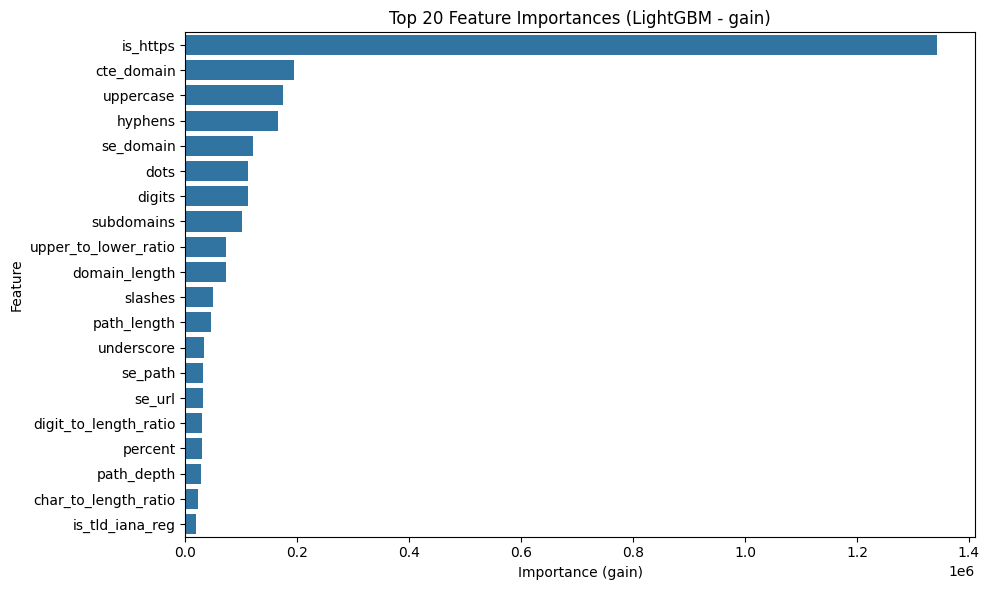

In [9]:
# Block: LightGBM Feature Importance (uses X_sample / y_sample)

# install if needed: pip install lightgbm
from lightgbm import LGBMClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train
lgb_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_sample, y_sample)

# get importances (use 'gain' for a more informative ranking)
gain = lgb_model.booster_.feature_importance(importance_type='gain')
split = lgb_model.booster_.feature_importance(importance_type='split')

lgb_importances = pd.DataFrame({
    "feature": X_sample.columns,
    "importance_gain": gain,
    "importance_split": split
}).sort_values("importance_gain", ascending=False)

# print top 20 by gain
print(lgb_importances[["feature", "importance_gain"]].head(20))

# plot (same style as before)
plt.figure(figsize=(10,6))
sns.barplot(
    x="importance_gain",
    y="feature",
    data=lgb_importances.head(20),
)
plt.title("Top 20 Feature Importances (LightGBM - gain)")
plt.xlabel("Importance (gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


                  feature  importance
15               is_https    0.351516
28             cte_domain    0.057852
24              se_domain    0.055982
23                 se_url    0.041848
4                 hyphens    0.040485
32             subdomains    0.034875
17          domain_length    0.034871
0                    dots    0.034148
25                se_path    0.033917
34  digit_to_length_ratio    0.031863
13              uppercase    0.026799
35   char_to_length_ratio    0.026446
18            path_length    0.022560
16             url_length    0.021915
3                 slashes    0.021671
12              lowercase    0.021562
14   upper_to_lower_ratio    0.020682
7                  digits    0.020506
19             path_depth    0.019835
9              underscore    0.010754


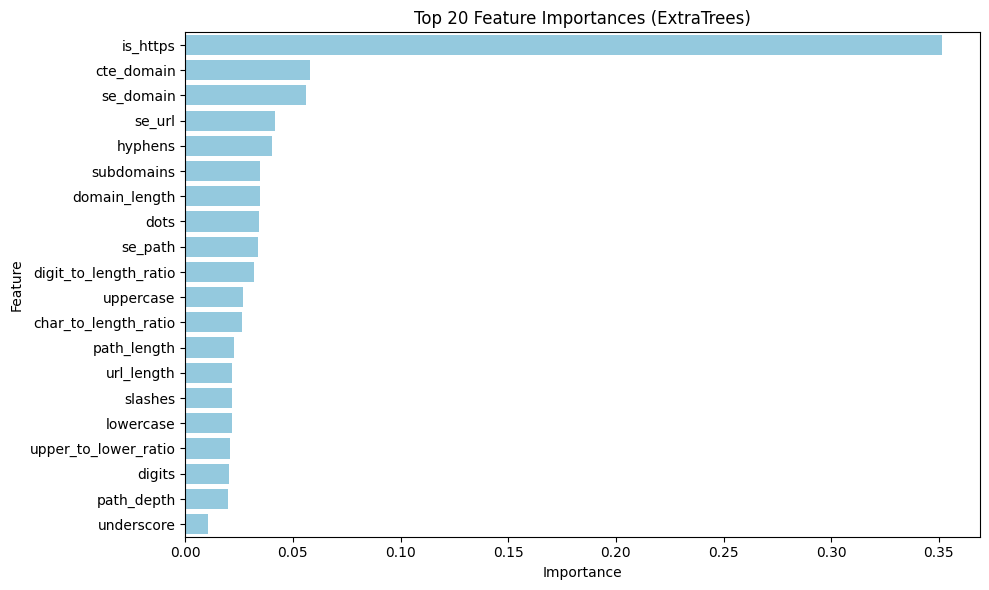

In [10]:
# Block: ExtraTrees Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train ExtraTrees
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et_model.fit(X_sample, y_sample)

# Feature importances
et_importances = pd.DataFrame({
    "feature": X_sample.columns,
    "importance": et_model.feature_importances_
}).sort_values("importance", ascending=False)

# Print top 20
print(et_importances.head(20))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x="importance",
    y="feature",
    data=et_importances.head(20),
    color="skyblue"
)
plt.title("Top 20 Feature Importances (ExtraTrees)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
